This notebook was created because notebook13 was getting to long and we had achieved at least most of what that notebook was intended for (creating the thickness weight vector, beginning to get some more reasonable balances). Now, in notebook 14, I'm going to play around with how hbl is defined in time more specifically. At the end of notebook 13, I had a few balance attempts where the budget was balanced just by looking at the max hbl in every 24 hour period. I'm going to take Dimitris' advice now and go with the approximately 7am hbl (right before sunrise where you would expect the hbl to be at its diurnal peak, all other signals aside). 

In [2]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import dask_ndfilters
# How about visualization?
%matplotlib inline
from xmovie import Movie
import xrscipy.signal as dsp
import xrft
import scipy.signal as scp
import netCDF4
import xgcm
from netCDF4 import Dataset
import time as tm
from xmitgcm import open_mdsdataset
import time as tm
import pylab as plt
from llcmap_bi_split import LLCMap_bi_split
from face_connections import face_connections
from llcmap_nea_split import LLCMap_nea_split
from timeline_MITgcm import timeline
from datetime import datetime, timedelta
import importlib
from GetNCDataSet import getNCDataSet
from MITllc2160Depth import *
#GetNCDataSet = importlib.reload(GetNCDataSet)

from dask.distributed import Client
client = Client(memory_limit='30GB',n_workers = 10, threads_per_worker=1)

ERROR! Session/line number was not unique in database. History logging moved to new session 361


/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36975 instead
  warnings.warn(


In [3]:
import scipy.io
os.chdir("//nobackup//amondal//Python//Hector_Python_Scripts")
print(os.getcwd())
thk = scipy.io.loadmat('thk90')

thk90 = thk['thk90']
dpt90 = thk['dpt90']
#dpt90
depth_tick_nums = thk['dpt90'][0, 0:90]
#depth_tick_nums
depth = depth_tick_nums
np.max(np.nonzero(np.where(depth < 250, depth, 0)))

/nobackupp12/amondal/Python/Hector_Python_Scripts


29

In [38]:
zlayerToDepth(33)

325.31999999999994

In [4]:
# good - now, let me make a bunch of .nc files:
fol = "/nobackup/amondal/NCData/20210830_RegBal_5day/"
VAR = "Zeta"
firstlevel = 0
finallevel = 1
Zeta = getNCDataSet(fol,VAR, firstlevel,finallevel)
Q = getNCDataSet(fol,'oceQnet', 0,1)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [5]:
# good - now, let me make a bunch of .nc files:
#fol = "/nobackup/amondal/NCData/20210802_FBB/"
VAR = "KPPhbl"
firstlevel = 0
finallevel = 1
hbl = getNCDataSet(fol,VAR, firstlevel,finallevel)

Time combined dataset has been opened.
I concatenated the first Z-layer


In [6]:
hbl = hbl.compute()

In [7]:
hblfilt = dsp.lowpass(dsp.lowpass(dsp.lowpass(hbl['KPPhbl'], 1.0/0.4,dim='lat' ), 1.0/0.4, dim='lon'), 1.0 / 48.0, dim='time')

In [ ]:
hblfilt

In [8]:
# good - now, let me make a bunch of .nc files:
fol = "/nobackup/amondal/NCData/20210830_RegBal_5day/"
VAR = "Theta"
firstlevel = 0
finallevel = 36
Theta = getNCDataSet(fol,VAR, firstlevel,finallevel)
HAdv = getNCDataSet(fol, 'HAdv', 0, 36)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been 

So there's an interesting point - where we throw in the compute function is an interesting question. Because, we can't plot what we haven't done a compute() on.

In [9]:
Zeta = Zeta.compute()
Q = Q.compute()
hbl = hbl.compute()
Theta = Theta.compute()
HAdv = HAdv.compute()

In [10]:
rhoConst = 1027.5 #kg/m^3
Cp = 1*(10**3) # J / (kg K)

In [11]:
latsel = 34.9
lonsel = -64.8
#hblsel = hbl['KPPhbl'].sel(lat=latsel,lon=lonsel,method='nearest')
#zetasel = Zeta['Zeta'].sel(lat=latsel,lon=lonsel,method='nearest')
#qsel = Q['oceQnet'].sel(lat=latsel,lon=lonsel,method='nearest')
#HAdvsel = HAdv['HAdv'].sel(lat=latsel,lon=lonsel,method='nearest')
#Thetasel = Theta['Theta'].sel(lat=latsel,lon=lonsel,method='nearest')

In [ ]:
#HAdvsel = HAdvsel[0:48].compute()
#Thetasel = Thetasel[0:48].compute()
#hblsel = hblsel[0:48].compute()
#zetasel = zetasel[0:48].compute()
#qsel = qsel[0:48].compute()

First example of the block of code to determine how hbl is chosen for our balance:

In [ ]:
#periodnum = hblsel.dims['time'] / 24 # this will be useful in the future

periodnum = 2 # for now, I will artificially set this as such
periodlength = 24 # a constant

perioddepths = np.empty(periodnum)
hblcoarsegrain = np.empty(0)
for index in range(0,periodnum):
    perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
    hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
hmMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)

-----------------------------------------------------------
Below, I'm putting in a more generic bit of code to repeat what I've been doing before (9/15 update). I'm going to try to evaluate different hbl values using a goodness of fit so I'm going to make some more modular code.
-----------------------------------------------------------

In [12]:
def coarseGrainHbl_MAX(hblset, latsel, lonsel):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl'].sel(lat=latsel,lon=lonsel,method='nearest')
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

In [14]:
MAXtest = coarseGrainHbl_MAX(hbl, latsel, lonsel)

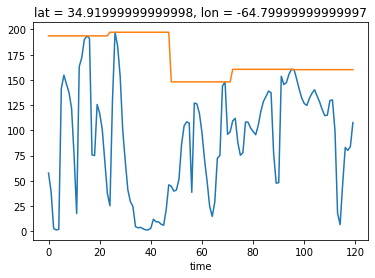

In [15]:
%matplotlib inline
hblsel = hbl['KPPhbl'].sel(lat=latsel,lon=lonsel,method='nearest')
hblsel.plot()
MAXtest.plot()

In [16]:
def coarseGrainHbl_SUNRISE(hblset, latsel, lonsel):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl'].sel(lat=latsel,lon=lonsel,method='nearest')
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    sunrisetime = 10 #NOTE IN A FINAL VERSION OF THIS CODE, SUNRISE TIME WILL BE A FUNCTION OF LONGITUDE
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength + sunrisetime].values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hSUNRISE = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hSUNRISE

In [41]:
def coarseGrainHbl_LPFilter(hblset,latsel,lonsel):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblfilt = dsp.lowpass(dsp.lowpass(dsp.lowpass(hblset['KPPhbl'], 1.0/0.4,dim='lat' ), 1.0/0.4, dim='lon'), 1.0 / 48.0, dim='time')
    hblsel = hblfilt.sel(lat=latsel,lon=lonsel,method='nearest')
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    sunrisetime = 10 #NOTE IN A FINAL VERSION OF THIS CODE, SUNRISE TIME WILL BE A FUNCTION OF LONGITUDE
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength + sunrisetime].values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hSUNRISE = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hSUNRISE
def coarseGrainHbl_CONST(hblset,latsel,lonsel):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset.sel(lat=latsel,lon=lonsel,method='nearest')
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    sunrisetime = 10 #NOTE IN A FINAL VERSION OF THIS CODE, SUNRISE TIME WILL BE A FUNCTION OF LONGITUDE
    for index in range(0,periodnum):
        perioddepths[index] = zlayerToDepth(32)
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hSUNRISE = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hSUNRISE

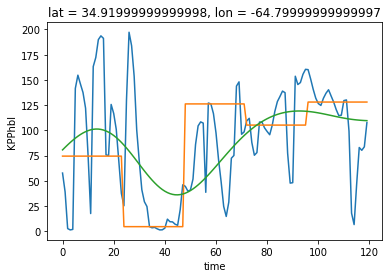

In [18]:
SUNRISEtest = coarseGrainHbl_SUNRISE(hbl, latsel, lonsel)
%matplotlib inline
hblsel = hbl['KPPhbl'].sel(lat=latsel,lon=lonsel,method='nearest')
hblsel.plot()
hblselfilt = hblfilt.sel(lat=latsel,lon=lonsel,method='nearest')
SUNRISEtest.plot()
hblselfilt.plot()

In [19]:
def getThetaTendency(hblcoarsegrain, Theta, latsel, lonsel):
    hblcg = hblcoarsegrain.values #hblcoarse grain is a dataarray and getThickWeightedVector takes dataarrays
    weightVector = getThickWeightedVector(hblcg)
    wv = np.swapaxes(weightVector, 0, 1)
    Thetasel = Theta['Theta'].sel(lat=latsel,lon=lonsel,method='nearest')
    wpdf = xr.DataArray(data = wv, dims = Thetasel.dims, coords = Thetasel.coords)
    weightedThetaSel = (Thetasel[0:wpdf.shape[0],:]*wpdf).sum(dim='Zlayers')
    ThetaTendency = weightedThetaSel.diff(dim='time') / (3600)
    return ThetaTendency

def getThetaTendencyEstimate(hblcoarsegrain, HAdv, Theta, Zeta, Q, latsel, lonsel):
    hblcg = hblcoarsegrain.values #hblcoarse grain is a dataarray and getThickWeightedVector takes dataarrays
    weightVector = getThickWeightedVector(hblcg)
    wv = np.swapaxes(weightVector, 0, 1)
    Thetasel = Theta['Theta'].sel(lat=latsel,lon=lonsel,method='nearest')
    zetasel = Zeta['Zeta'].sel(lat=latsel,lon=lonsel,method='nearest')
    qsel = Q['oceQnet'].sel(lat=latsel,lon=lonsel,method='nearest')
    HAdvsel = HAdv['HAdv'].sel(lat=latsel,lon=lonsel,method='nearest')
    wpdf = xr.DataArray(data = wv, dims = Thetasel.dims, coords = Thetasel.coords)
    weightedThetaSel = (Thetasel[0:wpdf.shape[0],:]*wpdf).sum(dim='Zlayers')
    weightedHAdv = (HAdvsel[0:wpdf.shape[0],:]*wpdf).sum(dim='Zlayers')
    ekman = zetasel / hblcoarsegrain * weightedThetaSel
    heatflux = qsel / (hblcoarsegrain * rhoConst * Cp)
    Estimate = weightedHAdv*-1 + ekman + heatflux
    return Estimate

In [20]:
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)

In [21]:
tendency.values

array([-9.30478528e-06, -3.03239263e-05, -2.32370942e-05, -2.44728863e-06,
        6.51024018e-06, -7.99469839e-06, -3.59260052e-05, -5.90487879e-05,
       -7.24502982e-05, -7.48487960e-05, -6.02642875e-05, -2.19074868e-05,
        2.38144892e-06,  2.61724222e-05,  5.33163325e-05,  7.42729256e-05,
        7.63237790e-05,  7.38785406e-05,  6.73876455e-05,  5.03252522e-05,
        1.75137638e-05, -3.33402592e-05, -8.48597909e-05, -7.66191321e-05,
        1.57877699e-05,  1.06813363e-04,  1.33937877e-04,  9.36051190e-05,
        4.58908339e-05,  7.18099304e-06, -4.25495556e-05, -9.53834640e-05,
       -1.09622244e-04, -7.19391662e-05, -4.90662953e-05, -3.15947428e-05,
       -2.42983939e-05, -2.33707272e-05, -4.06486872e-06,  2.60291732e-05,
        4.91386809e-05,  3.56166319e-05,  7.26848242e-06, -1.97969855e-05,
       -2.20134209e-05,  1.86942616e-06,  2.73184576e-05,  7.81124798e-05,
        3.30939729e-05,  3.44357155e-05,  4.54279956e-05,  5.23195530e-05,
        6.59383475e-05,  

In [22]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2)

hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
%matplotlib inline
tendency.plot(ax = axes[0])
Estimate.plot(ax = axes[0])
#----------------------------
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
%matplotlib inline
tendencyS.plot(ax = axes[1])
EstimateS.plot(ax = axes[1])
#
# This cell just contains a list of code that is useful for plots. Actual implementation is further down
#
#

plt.show()

In [ ]:
%matplotlib inline
latsel = 34.9
lonsel = -65.9
fig, axes = plt.subplots(ncols=3, figsize =[15,5])
axes
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendency.plot(ax = axes[0])
Estimate[1:].plot(ax = axes[0])
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendencyS.plot(ax = axes[1])
EstimateS[1:].plot(ax = axes[1])
hblcgC = coarseGrainHbl_CONST(hbl,latsel,lonsel)
tendencyC = getThetaTendency(hblcgC, Theta, latsel, lonsel)
EstimateC = getThetaTendencyEstimate(hblcgS, HAdv, Theta,Zeta,Q, latsel,lonsel)
tendencyC.plot(ax = axes[2])
EstimateC[1:].plot(ax = axes[2])
plt.setp(axes[0], xlabel='time (hours)')
plt.setp(axes[0], title='MAX hbl')
plt.setp(axes[1], xlabel='time (hours)')
plt.setp(axes[1], title='Sunrise hbl')
plt.xlabel('time (hours)')
plt.title('CONST hbl')
plt.legend(labels=['tendency', 'estimate'])
plt.show()

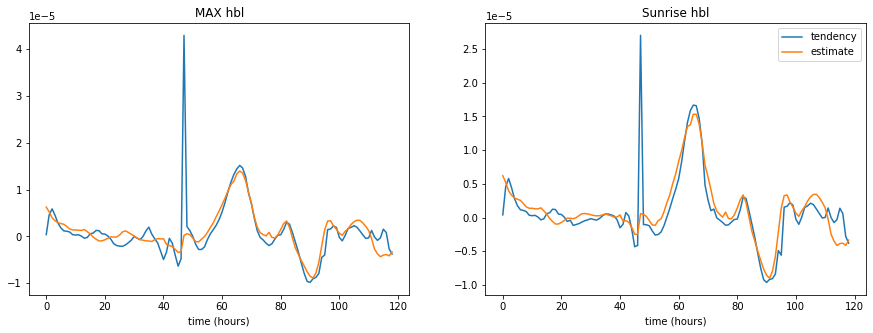

In [24]:
%matplotlib inline
latsel = 34.04
lonsel = -64.04
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendency.plot(ax = axes[0])
Estimate[1:].plot(ax = axes[0])
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendencyS.plot(ax = axes[1])
EstimateS[1:].plot(ax = axes[1])
plt.setp(axes[0], xlabel='time (hours)')
plt.setp(axes[0], title='MAX hbl')
plt.xlabel('time (hours)')
plt.title('Sunrise hbl')
plt.legend(labels=['tendency', 'estimate'])
plt.show()

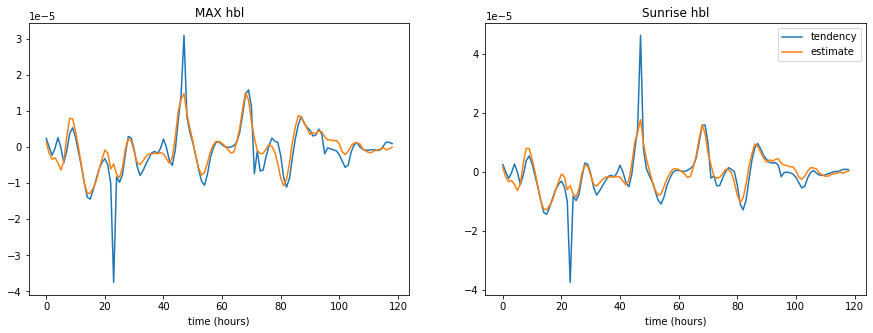

In [25]:
%matplotlib inline
latsel = 34.504
lonsel = -65.75
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendency.plot(ax = axes[0])
Estimate[1:].plot(ax = axes[0])
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendencyS.plot(ax = axes[1])
EstimateS[1:].plot(ax = axes[1])
plt.setp(axes[0], xlabel='time (hours)')
plt.setp(axes[0], title='MAX hbl')
plt.xlabel('time (hours)')
plt.title('Sunrise hbl')
plt.legend(labels=['tendency', 'estimate'])
plt.show()

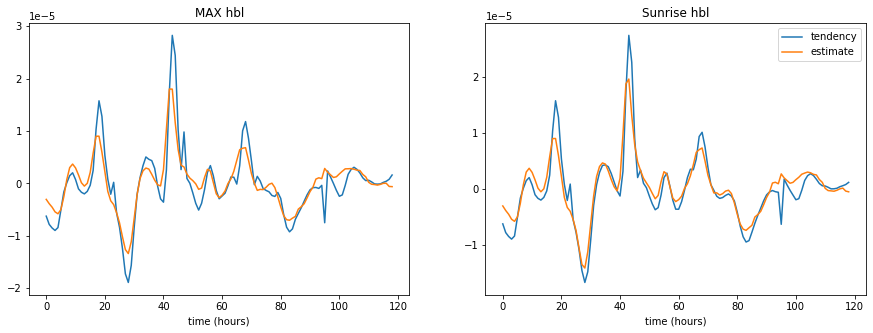

In [26]:
%matplotlib inline
latsel = 34.34
lonsel = -65.23
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendency.plot(ax = axes[0])
Estimate[1:].plot(ax = axes[0])
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendencyS.plot(ax = axes[1])
EstimateS[1:].plot(ax = axes[1])
plt.setp(axes[0], xlabel='time (hours)')
plt.setp(axes[0], title='MAX hbl')
plt.xlabel('time (hours)')
plt.title('Sunrise hbl')
plt.legend(labels=['tendency', 'estimate'])
plt.show()

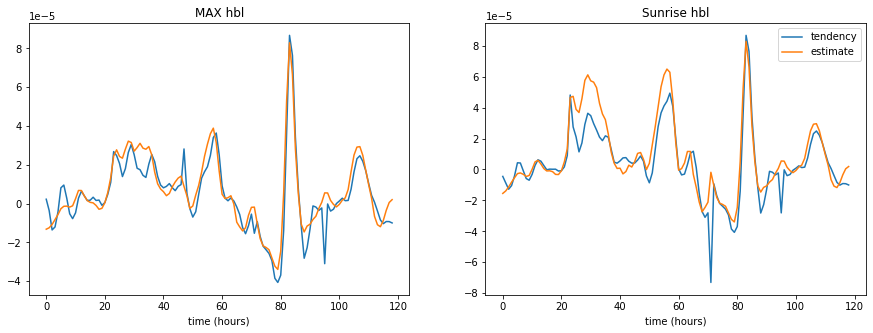

In [27]:
%matplotlib inline
latsel = 35
lonsel = -64.
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
hblcg = coarseGrainHbl_MAX(hbl, latsel,lonsel)
tendency = getThetaTendency(hblcg, Theta, latsel,lonsel)
Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendency.plot(ax = axes[0])
Estimate[1:].plot(ax = axes[0])
hblcgS = coarseGrainHbl_SUNRISE(hbl, latsel,lonsel)
tendencyS= getThetaTendency(hblcgS, Theta, latsel,lonsel)
EstimateS = getThetaTendencyEstimate(hblcgS, HAdv, Theta, Zeta, Q, latsel, lonsel)
tendencyS.plot(ax = axes[1])
EstimateS[1:].plot(ax = axes[1])
plt.setp(axes[0], xlabel='time (hours)')
plt.setp(axes[0], title='MAX hbl')
plt.xlabel('time (hours)')
plt.title('Sunrise hbl')
plt.legend(labels=['tendency', 'estimate'])
plt.show()

In [28]:
# I'll start with a goodness of fit calculation.
#lat1 goes from 34 to 35
#lon1 goes from -65 to -64
ChiSqrMAX = 0
for latindex in np.arange(34,35,0.04):
    for lonindex in np.arange(-65, -64, 0.04):
        hblcg = coarseGrainHbl_MAX(hbl, latindex,lonindex)
        tendency = getThetaTendency(hblcg, Theta, latindex,lonindex)
        Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latindex, lonindex)
        tensqr = tendency*tendency
        estsqr = Estimate*Estimate
        ChiSqrMAX = ChiSqrMAX + (estsqr[1:] - tensqr) / (tensqr * 625)

ChiSqrSUN = 0
for latindex in np.arange(34,35,0.04):
    for lonindex in np.arange(-65, -64, 0.04):
        hblcg = coarseGrainHbl_SUNRISE(hbl, latindex,lonindex)
        tendency = getThetaTendency(hblcg, Theta, latindex,lonindex)
        Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latindex, lonindex)
        tensqr = tendency*tendency
        estsqr = Estimate*Estimate
        ChiSqrSUN = ChiSqrSUN + (estsqr[1:] - tensqr) / (tensqr * 625)


In [29]:
(tensqr - estsqr[1:])/(tensqr)

<xarray.DataArray (time: 119)>
array([-1.08833069e+01, -1.56870895e+00,  2.13818304e-01,  3.80029013e-01,
       -6.46991840e-01,  6.21413759e-01,  7.12955552e-01, -1.17648587e+01,
        4.07013583e-01,  6.88693512e-01,  9.99041613e-01, -2.54628941e+00,
        9.92636500e-02,  5.61567452e-01,  9.43815492e-01, -2.63667733e+01,
       -1.36915227e+01, -8.50109136e+01, -2.79910557e+02, -9.29156383e+00,
       -1.22432894e-01, -7.45443996e+00, -1.21010547e+00,  6.27335643e-02,
       -1.95703804e+00, -2.38781475e+00, -9.46504677e+00, -6.11808487e+00,
       -2.90930619e+00, -1.83347287e+00, -1.71201234e+00, -2.61915858e+00,
       -3.31461531e+00, -3.18012683e+00, -2.70958028e+00, -1.19316202e+00,
       -2.01180593e-01,  2.48762411e-01,  2.72941456e-01,  9.72127738e-01,
        9.77729958e-01,  8.54788704e-01,  9.69298862e-01,  7.28763491e-01,
        8.48746397e-01, -4.65451509e-01, -1.92226414e+00, -5.85363548e-01,
       -4.94390183e-01,  9.99511090e-01,  7.86380284e-01, -5.05159822e+01,
       -3.67475289e+00, -1.13668494e+00, -1.13721219e+00, -1.21657079e+00,
       -1.16963837e+00, -6.21763681e-01, -2.08280913e-01,  2.42986650e-01,
       -1.73288027e-01,  9.76713787e-01, -9.86348887e-01, -1.25240563e+01,
       -2.34178417e-01,  9.27137624e-01, -8.07694153e+01, -8.98528876e-01,
       -1.08747402e-02,  3.70814063e-01,  4.31185648e-01,  9.99380025e-01,
       -2.50920417e-01, -1.34657106e-01,  1.59247502e-02,  9.61884814e-02,
        1.42713982e-01,  9.06060853e-02,  2.98117893e-01,  3.03138055e-01,
        5.56863342e-01,  8.62560692e-01, -1.13509178e+00,  8.65391669e-02,
        2.45023358e-01,  3.22445853e-01,  5.64759341e-01,  1.84918577e-01,
        7.30774164e-01,  7.41143617e-01,  3.39006540e-01, -4.50983341e+01,
       -1.23057162e+01,  4.92755783e-01,  9.09253645e-01,  9.61814361e-01,
       -5.96914959e+02,  8.78083645e-01,  9.41396356e-01, -1.56929647e+01,
        2.99599577e-01,  5.48763614e-01, -4.38338208e+00, -2.19264389e+01,
       -3.97673208e+00, -1.35326832e+00, -5.95775707e-01, -4.15759446e-01,
       -2.77282346e-01, -1.14452322e-03,  1.63073900e-01,  6.14286917e-01,
       -1.17061414e+02, -6.57609793e+00, -9.78972089e-01,  2.84918795e-01,
        8.55675124e-01,  9.97443684e-01,  9.63872793e-01])
Coordinates:
    lat      float64 34.96
    lon      float64 -64.04
Dimensions without coordinates: time

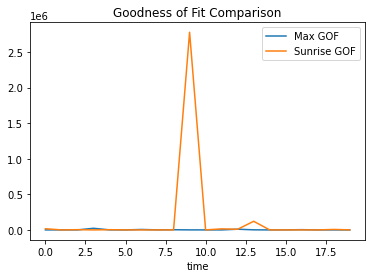

In [30]:
ChiSqrMAX[0:20].plot()
ChiSqrSUN[0:20].plot()
plt.title('Goodness of Fit Comparison')
plt.legend(labels=['Max GOF', 'Sunrise GOF'])

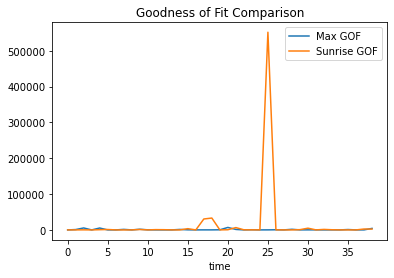

In [31]:
ChiSqrMAX[80:120].plot()
ChiSqrSUN[80:120].plot()
plt.title('Goodness of Fit Comparison')
plt.legend(labels=['Max GOF', 'Sunrise GOF'])

In [32]:
# Here, I'll just do a residual average - that might be a little less worrying
#lat1 goes from 34 to 35
#lon1 goes from -65 to -64
resMAX = 0
for latindex in np.arange(34,35,0.04):
    for lonindex in np.arange(-65, -64, 0.04):
        hblcg = coarseGrainHbl_MAX(hbl, latindex,lonindex)
        tendency = getThetaTendency(hblcg, Theta, latindex,lonindex)
        Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latindex, lonindex)
        resMAX += abs(Estimate[1:] - tendency)*abs(Estimate[1:] - tendency)

resSUN = 0
for latindex in np.arange(34,35,0.04):
    for lonindex in np.arange(-65, -64, 0.04):
        hblcg = coarseGrainHbl_SUNRISE(hbl, latindex,lonindex)
        tendency = getThetaTendency(hblcg, Theta, latindex,lonindex)
        Estimate = getThetaTendencyEstimate(hblcg, HAdv, Theta, Zeta, Q, latindex, lonindex)
        resSUN += abs(Estimate[1:] - tendency)*abs(Estimate[1:] - tendency)


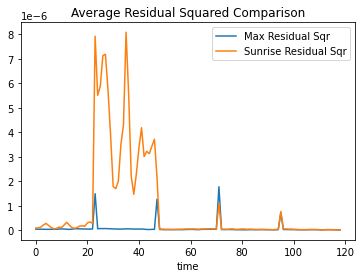

In [33]:
resMAX.plot()
resSUN.plot()
plt.title('Average Residual Squared Comparison')
plt.legend(labels=['Max Residual Sqr', 'Sunrise Residual Sqr'])

So with the exception of one weird point in time, these two look decently similar. Hard to confidently pick one over the other without considering more possibilities.

Here's another idea - let's apply a filter to hbl. Get rid of anything synoptic. Or do we get rid of things that are faster than diurnal? This should wait until we've talked to Patrice.

-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
old code below (9/13-9/14)

(9/14) So update from the last Markdown note. It seems like I'm going to need a more quantitative way of telling which method of determining hbl is going to give me the best fit. I should also begin loading in that 5 day sample for more data. I should calculate some kind of residual function over each fit at each location in space and tabulate the results.

At the same time, I should see if Patrice can help understand how the goodness of the fit (so to speak, no chi squares around here) is correlated to the craziness of the corresponding hbl plots - it seems like there is a connection.

(9/16) Patrice's suggestion - do a constant depth much deeper than the reported hbl value. Trying to tease out artifacts of the hbl will take too long and will still not lead to much. Try a constant depth throughout.